## Observaciones (Fetures) Sinteticas and Atipicas (Outliers)
  * Crear una observacion sintetica que es el radio de otras dos observaciones
  * Usar esta nueva observacion comod entrada/input a un model de regresion lineal
  * Mejorar la efectividad del model identificando y removiendo outliers de los datos de entrada


Utilicemos el model del ejercicio Primeros Paso en TensorFlow.

Primero, importemos los datos de casas en California, usando *pandas* `DataFrame`:


In [16]:
# Copia directa de Google source
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("./california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10667,-120.6,35.1,15.0,5818.0,924.0,2324.0,845.0,4.4,267.6
6564,-118.3,34.1,49.0,3828.0,1197.0,2862.0,1009.0,2.5,219.2
15548,-122.3,37.6,50.0,1975.0,245.0,644.0,251.0,10.1,500.0
5370,-118.2,34.0,42.0,2729.0,725.0,3004.0,722.0,2.3,154.3
14547,-122.2,37.5,30.0,4198.0,1244.0,2678.0,1147.0,3.7,308.6
...,...,...,...,...,...,...,...,...,...
5840,-118.2,34.0,36.0,2672.0,675.0,2883.0,674.0,2.1,142.8
12589,-121.7,38.2,46.0,2292.0,472.0,970.0,431.0,2.3,94.9
265,-116.6,34.0,20.0,260.0,67.0,69.0,50.0,3.5,76.6
16338,-122.5,38.0,39.0,3302.0,684.0,1574.0,653.0,3.7,263.8


**Paso Siguiente**, tenemos que definir la funcion de entrada/input, y definir la funcion para el entrenamiento de modelo:



In [17]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [18]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

## Ejercicio 1: Uso de Objservacion Sintetica (Synthetic Feature)

Ambas observacion `total_rooms` y `population` cuentan totales para un determinado bloque en la ciudad

Que ocurriria si uno de los bloques estan con mas alta densidad poblacional que los otros? Podemos explorar como la densidad de los bloques se correlacionan al valor medio de las casas, para hacer esto tenemos que crear una observacion sintetica que sea la relacion (coeficiente) de `total_rooms` y `poblacion`.

En la siguiente celda, cree una observacion llamada `rooms_per_person`, y usela como `input_feature` para `train_model()`

Cual el el mejor resultado de rendimiento que puede alcanzar con esta sola observacion modificando solo el coeficiente de aprendizaje?  (Entre mejor sea el rendimiento, mejor es la linea de regresion que se ajusta a los datos, y mas bajo el valor final de RMSE.) 



**NOTA**: Pruebe el ejercicio con varios coeficientes de apredizaje y compare los resultados.  


Training model...
RMSE (on training data):
  period 00 : 212.77
  period 01 : 189.97
  period 02 : 169.91
  period 03 : 152.38
  period 04 : 140.54
  period 05 : 134.35
  period 06 : 130.93
  period 07 : 131.49
  period 08 : 132.59
  period 09 : 132.77
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.6,207.3
std,92.6,116.0
min,45.1,15.0
25%,164.3,119.4
50%,197.5,180.4
75%,225.7,265.0
max,4418.7,500.0


Final RMSE (on training data): 132.77


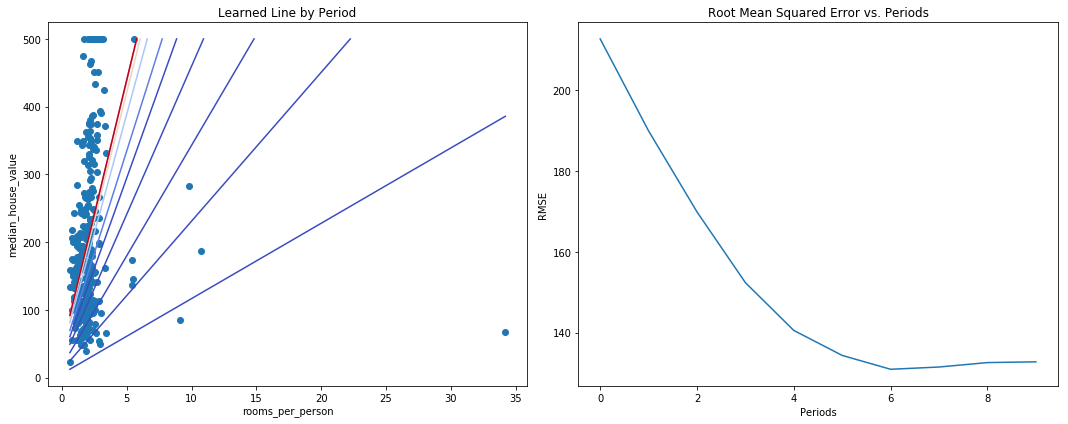

In [19]:
#
# Calculo de cuartos por persona 
#
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

## Ejercicio 2: Identificando Observaciones Atipicas (Outliers)
Puedemos visualizar el rendimiento de nuestro modelo si creamos un diagrama (scatter plot) con valores de predicciones vs. objetivos. Idealmente, todos estarian ubicados perfectamente correlacionados en una linea diagonal.

Utilice Pyplot's [`scatter()`](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) para crear un plot de este tipo, utilizando el modelo de los cuartos-por-persona que se entreno en el Ejercicio 1 arriba. 

Que ve extranio? Compare contra los datos fuente observando la distribucion de valores en `rooms_per_person`.



## Task 2: Identify Outliers
​
We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.
​
Use Pyplot's [`scatter()`](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) to create a scatter plot of predictions vs. targets, using the rooms-per-person model you trained in Task 1.
​
Do you see any oddities?  Trace these back to the source data by looking at the distribution of values in `rooms_per_person`.

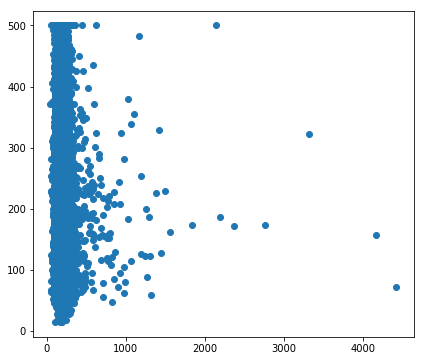

In [20]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

Los datos de calibracion muestran la mayoria de los puntos alineados (en una linea es casi vertical). Enfoquemonos en los que estan lejos, note que son relativamente pocos.

Si graficamos un histagrama de rooms_per_person, veremos que tenemos unos cuantos casos atipicos en nuestros datos:


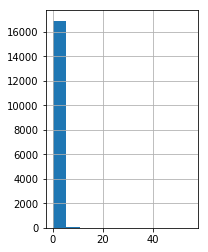

In [21]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

## Ejercicio 3: Removiendo los casos Atipicos
Verifique si puede mejorar el modelo, ajustando los valores atipicos de `rooms_per_person` a algunos valores minimo o maximo rasonables.  Por referencia, aqui hay un ejemplo de como aplicar una funcion a una `Serie` de Pandas:

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))
    
La variable `clipped_feature` no tengra ningun valor menor de cero `0`.

### Solucion
El histagrama creado en el Ejercicio 2 (arriba) muestra la mayoria de valores son menos de `5`.  Removamos los valores de `rooms_per_person` mayores de 5, y creemos la grafica histograma para verificar los resultados.



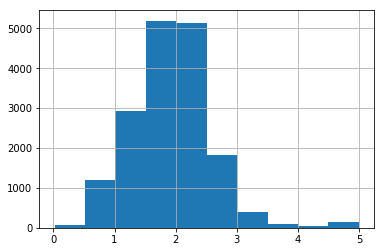

In [23]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

Para verificar que fueron removidos, entrenemos de nuevo e imprimamos los datos de calibracion una vez mas:


Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.08
  period 02 : 166.74
  period 03 : 146.53
  period 04 : 130.20
  period 05 : 118.25
  period 06 : 111.80
  period 07 : 108.75
  period 08 : 108.15
  period 09 : 107.85
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,201.2,207.3
std,52.5,116.0
min,47.3,15.0
25%,167.7,119.4
50%,201.2,180.4
75%,229.8,265.0
max,446.1,500.0


Final RMSE (on training data): 107.85


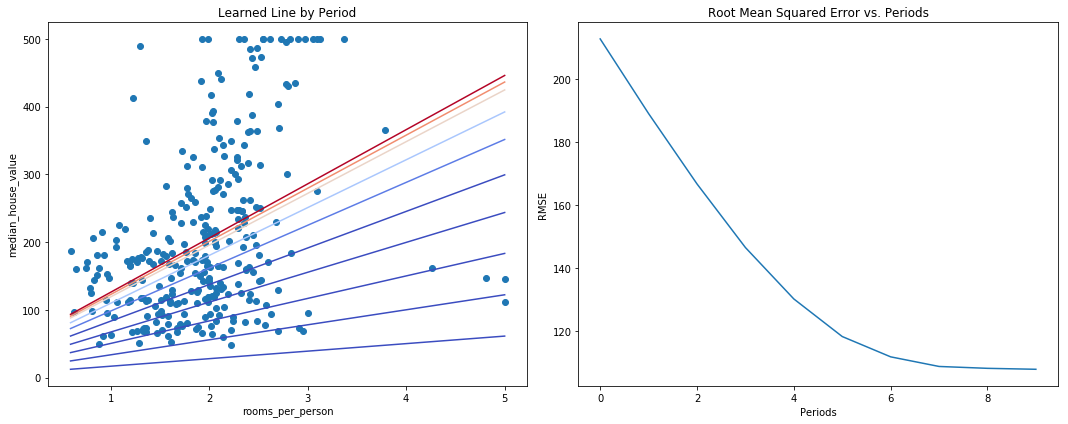

In [24]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

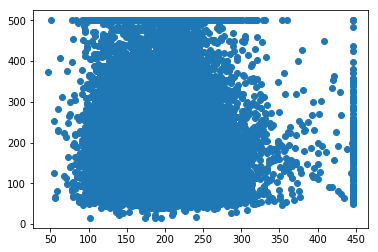

In [25]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])


Muchos de los ejercicios continen los siguientes **hiperparametros**:

* Pasos (steps), se refieren al numero total de iteraciones en entrenamiento. Un paso calcula la perdida de un lote (batch), y utiliza ese valor para modificar los pesos (weights) del modelo una vez.
* Lote (batch size), se refiere al numero de ejemplos (elegidos al azar) para un solo paso (step).  Por ejemplo, el tamanio de lote para SGD es uno (1).  La siguiente formula aplica:

        `numero total de ejemplos entrenados = tamano_lote * pasos`

La siguiente **variable** se utiliza bastante en los ejemplos de ML:

* periodos, controlan la granularidad del reporte. Por ejemplo, si el valor de periodos es definito como 7, y los pasos como 70, entonces el ejercicio mostrara el valor de perdida cada 10 pasos (o 7 veces).  A diferencia de los hyperparametros, este valor no altera la forma en la cual el modelo aprende. La siguiente formula aplica:

        `numero de ejemplos entrenados en cada periodo = tamano_lote * pasos / periodos`

